# **Suryakanta Karan (M22AIE207) m22aie207@iitj.ac.in**

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/surya/CV_Assignment/Assignment_2/CV Executive Assignment 2')

Mounted at /content/drive


In [5]:
import cv2
import numpy as np
import re

# Task 1: Stereo 3D Reconstruction

In [10]:
# Load images
image_left = cv2.imread('bikeL.png', 0)
image_right = cv2.imread('bikeR.png', 0)

# Load camera parameters from text file
with open('bike.txt', 'r') as file:
    lines = file.readlines()
    # Extract numeric values using regular expressions
    cam0_values = re.findall(r"[-+]?\d*\.\d+|\d+", lines[0])
    cam1_values = re.findall(r"[-+]?\d*\.\d+|\d+", lines[1])
    baseline_value = float(re.findall(r"[-+]?\d*\.\d+|\d+", lines[2])[0])

    camera_matrix_left = np.array(cam0_values[:9]).reshape(3, 3).astype(float)
    camera_matrix_right = np.array(cam1_values[:9]).reshape(3, 3).astype(float)

# Perform stereo matching (Block matching)
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_map = stereo.compute(image_left, image_right)

# Calculate depth map
depth_map = np.zeros_like(disparity_map, dtype=np.float32)
depth_map[disparity_map > 0] = baseline_value * np.divide(1, disparity_map[disparity_map > 0])

# Construct the Q matrix
Q = np.float32([[1, 0, 0, -camera_matrix_left[0, 2]],
                [0, 1, 0, -camera_matrix_left[1, 2]],
                [0, 0, 0, camera_matrix_left[0, 0]],
                [0, 0, -1/baseline_value, 0]])

# Create 3D point cloud
points_3d = cv2.reprojectImageTo3D(disparity_map, Q=Q)


# Save disparity map and depth map
cv2.imwrite('disparity_map.png', disparity_map)
cv2.imwrite('depth_map.png', depth_map)

# Save 3D point cloud
np.save('point_cloud.npy', points_3d)


# Task 2: Epipolar Lines and Correspondences

[[ 3.34638533  7.          7.58547151]
 [-5.83765868  6.          1.36498636]
 [ 1.45892349  3.         -4.37648316]]
(3, 3)


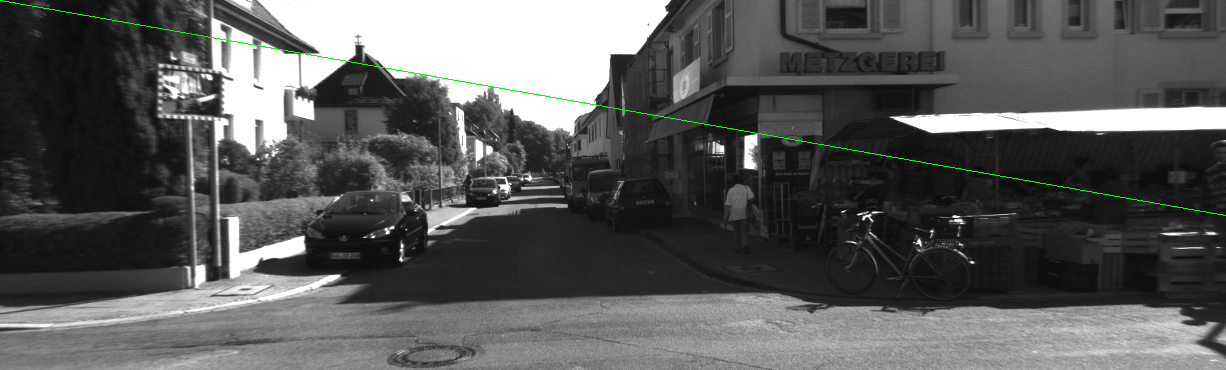

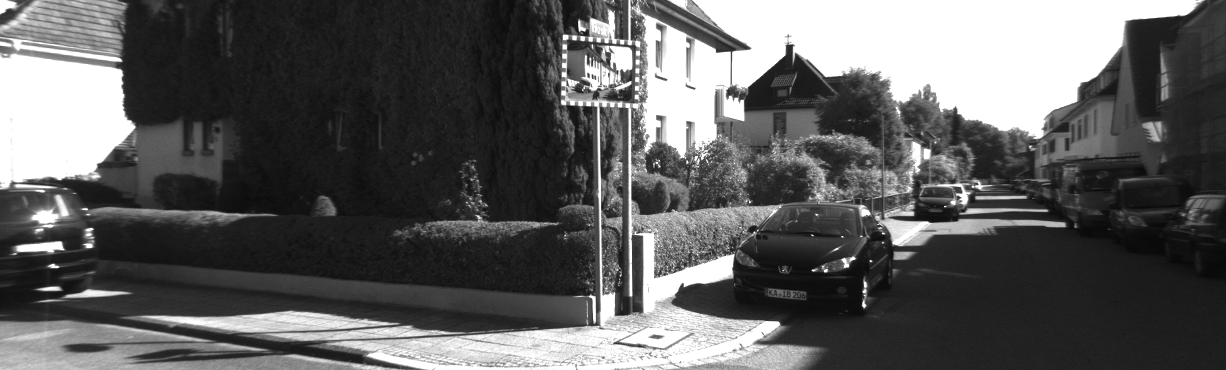

In [18]:
from google.colab.patches import cv2_imshow

# Load images
image1 = cv2.imread('000000.png')
image2 = cv2.imread('000023.png')

# Load fundamental matrix from text file
with open('FM.txt', 'r') as file:
    lines = file.readlines()
    # Extract numeric values using regular expressions
    F_values = []
    for line in lines:
        values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        if values:
            F_values.append([float(value) for value in values[:3]])

    F = np.array(F_values)

# Ensure fundamental matrix is of correct size (3x3)
if F.shape != (3, 3):
    raise ValueError("Fundamental matrix is not of size 3x3")

print(F)
print(F.shape)






# Find epilines corresponding to points in second image and draw them on first image
lines1 = cv2.computeCorrespondEpilines(np.float32([(10, 10)]), 2, F)
lines1 = lines1.reshape(-1, 3)
img1_with_lines = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
img1_with_lines = cv2.cvtColor(img1_with_lines, cv2.COLOR_GRAY2BGR)
for line in lines1:
    x0, y0, x1, y1 = map(int, [0, -line[2]/line[1], image1.shape[1], -(line[2]+line[0]*image1.shape[1])/line[1]])
    cv2.line(img1_with_lines, (x0, y0), (x1, y1), (0, 255, 0), 1)

# Find epilines corresponding to points in first image and draw them on second image
lines2 = cv2.computeCorrespondEpilines(np.float32([(10, 10)]), 1, F)
lines2 = lines2.reshape(-1, 3)
img2_with_lines = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
img2_with_lines = cv2.cvtColor(img2_with_lines, cv2.COLOR_GRAY2BGR)
for line in lines2:
    x0, y0, x1, y1 = map(int, [0, -line[2]/line[1], image2.shape[1], -(line[2]+line[0]*image2.shape[1])/line[1]])
    cv2.line(img2_with_lines, (x0, y0), (x1, y1), (0, 255, 0), 1)

# Display images with epilines
cv2_imshow(img1_with_lines)
cv2_imshow(img2_with_lines)
cv2.waitKey(0)
cv2.destroyAllWindows()